### Introduction: 

In this project we will analyse simulated data provided by Starbucks which mimics customer behavior in relation to promotion offers on the Starbucks rewards mobile app.

In [1]:
# import libraries
import pandas as pd 
pd.set_option("display.max_columns", None)
import numpy as np
from scipy import stats
import json
import datetime
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

# setup warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Data

### read in json files
portfolio = pd.read_json("data/portfolio.json", orient="records", lines=True)
profile = pd.read_json("data/profile.json", orient="records", lines=True)
transcript = pd.read_json("data/transcript.json", orient="records", lines=True)

### display shape of each data frame
display(portfolio.shape, profile.shape, transcript.shape)

### display first row of each data frame
display(portfolio.head(1), profile.head(1), transcript.head(1))

(10, 6)

(17000, 5)

(306534, 4)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


#### portfolio

In [3]:
## Format and Explore data

### display column info of data set
display(portfolio.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


None

In [4]:
### display proportion of missing data for all selected columns
display(portfolio.isnull().mean())

reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

<h4>Data understanding of portfolio data set</h4>
<p>Data set containing offer ids and meta data about each offer (duration, type, etc.):
<ul>    
    <li>id (string): offer id</li>
    <li>offer_type (string): totally 3 offer types (BOGO, discount, informational)</li>
    <li>difficulty (int): minimum required spend to complete an offer in USD</li>
    <li>reward (int): reward given for completing an offer in USD</li>
    <li>duration (int): time in days for offer to be opened</li>
    <li>channels (list of strings): totally 4 channel types (web, email, mobile, social)</li>
</ul>
<p>Observations:
    
<ul>    
    <li>10 rows and 6 columns</li>
    <li>no missing values</li>
</ul>

In [6]:
#### profile

In [7]:
### display column info of data set
display(profile.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


None

<p>Explore gender data: 
<ul>
    <li>check type and size of categories</li>
</ul>

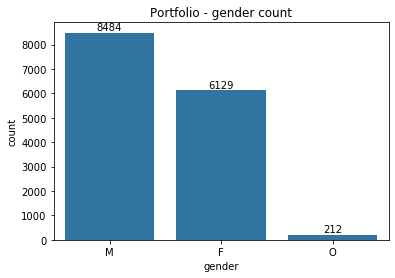

In [8]:
### define base color for bars
base_color = sns.color_palette()[0]
### define frequency with value counts in decreasing order of gender column
freq = profile["gender"].value_counts()
### get index of Series
gen_order = freq.index

### plot bar chart in decreasing order of gender value counts
plt.figure(figsize = [6,4])
sns.countplot(data = profile, x = "gender", color = base_color, order = gen_order)

### get current tick locations and labels
locs, labels = plt.xticks(rotation=0) 
### loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    ### get text property for label to get the correct count
    count = freq[label.get_text()]
    pct_string = "{}".format(count)
    ### print annotation just above top of the bar
    plt.text(loc, count+100, pct_string, ha = "center", color = "black")

plt.title("Portfolio - gender count")
plt.show();

<p>Explore age data: 
<ul>
    <li>check age distribution</li>
</ul>

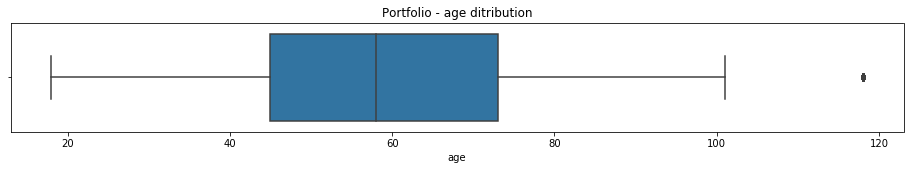

In [10]:
### define base color
base_color = sns.color_palette()[0]
### define figuere size of plot
plt.figure(figsize = [16,2])
### plot box plot showing outliers
sns.boxplot(x = profile["age"], color = base_color)
plt.title("Portfolio - age ditribution")
plt.show();

As we can see there are some values of age before 120 years. It's look like that's an outlier which has to be checked in detail later

<p>Format and explore become_member_on data:
<ul>
    <li>convert dtype from int64 to datetime64</li>
    <li>view chart with monthly registrations</li>
</ul>

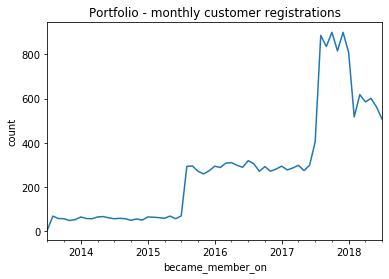

In [12]:
### convert Dtype from int64 to datetime64 in column "became_member_on"
profile["became_member_on"] = pd.to_datetime(profile.became_member_on.astype(str))

### specify Grouper for monthly counts of registrations
monthly_reg = profile.groupby([pd.Grouper(key="became_member_on", freq="M")])["became_member_on"].count()
### show line chart with registration date development
plt.figure(figsize = [6,4])
monthly_reg.plot(title = "Portfolio - monthly customer registrations", ylabel = "count");

<p>Explore income data: 
<ul>
    <li>check income distribution</li>
</ul>

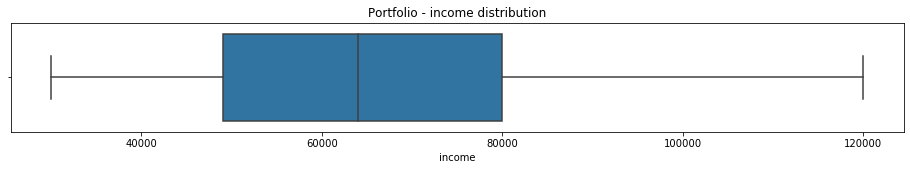

In [13]:
### define base color
base_color = sns.color_palette()[0]
### define figuere size of plot
plt.figure(figsize = [16,2])
### plot box plot showing outliers
sns.boxplot(x = profile["income"], color = base_color)
plt.title("Portfolio - income distribution")
plt.show();

<p>Explore missing and dulicated data: 
<ul>
    <li>check for missing data</li>
    <li>check for dulicated data</li>
</ul>

In [14]:
### display proportion of missing data for all selected columns
display(profile.isnull().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [15]:
### Check rows with age = 118
age_118 = profile[profile["age"] == 118]
display(age_118.count())

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

<p>There are exactly 2,175 customers with missing data for gender and income. Aside we have 2,175 customers with not realistic age of 118. 
Probably data for gender, income and age was simply not collected for those 2,175 customers at the registration process. We have here a data entry error where for gender and income no values were inserted and for age 118 was inserted.

<p>These 2,175 registrations are appr. 12.8 % of the total customers in the data set, which is not few. Nevertheless rather to compute a value for the missing data (by imputation), we decide to remove all these customers for the further data anaylsis process.

In [16]:
### check for duplicated data (duplicated users):
profile_dupicated = profile.duplicated().sum()
print("Duplicated rows:", profile_dupicated)

Duplicated rows: 0


<h4>Data understanding of profile data set</h4>
<p>Data set containing demographic data for each customer:
<ul>  
    <li>age (int): age of the customer</li>
    <li>became_member_on (int): date when customer created an app account</li>
    <li>gender (str): gender of the customer with totally 3 categories (M, F, O)</li>
    <li>id (string): customer id</li>
    <li>income (float): yearly customer's income in USD</li>
</ul>

<p>Observations:
<ul>  
    <li>17,000 rows and 5 columns</li>
    <li>age has 2175 values with 118 which must be an data entry error (outlier will be removed)</li>    
    <li>gender and income have each 2175 missing values which are in the same rows as the high age value of 118 which we consider as data entry error too</li>
    <li>became_member_on dtype has to be reformated from integer to datetime</li> 
    <li>no duplicated rows</li>
</ul>    

#### transcript

In [18]:
display(transcript.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


None

<p>Explore event data: 
<ul>
    <li>check type and size of categories</li>
</ul>

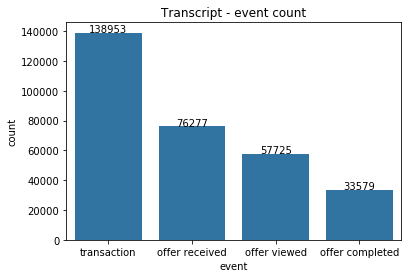

In [20]:
### define base color for bars
base_color = sns.color_palette()[0]
### define frequency with value counts in decreasing order of gender column
freq = transcript["event"].value_counts()
### get index of Series
gen_order = freq.index

### plot bar chart in decreasing order of gender value counts
plt.figure(figsize = [6,4])
sns.countplot(data = transcript, x = "event", color = base_color, order = gen_order)

### get current tick locations and labels
locs, labels = plt.xticks(rotation=0) 
### loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    ### get text property for label to get the correct count
    count = freq[label.get_text()]
    pct_string = '{}'.format(count)
    ### print annotation just above top of the bar
    plt.text(loc, count+100, pct_string, ha = "center", color = "black")

plt.title("Transcript - event count")
plt.show();

<p>Explore time data: 
<ul>
    <li>view chart with time registrations since start of test</li>
</ul>

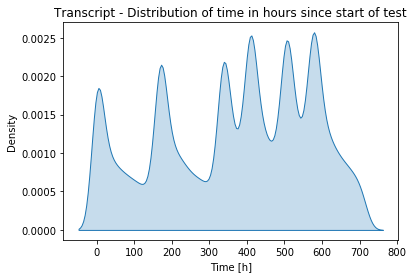

In [22]:
### line plot showing distribution of time
plt.figure(figsize = [6,4])
sns.distplot(transcript["time"], hist = False, kde_kws = {"shade": True})
plt.title("Transcript - Distribution of time in hours since start of test")
plt.xlabel("Time [h]");

<p>Explore transcript data set for one single customer: 
<ul>
    <li>view process with events and transactions of one customer for better understanding</li>
</ul>

In [23]:
### view all transcripts of one customer
single_customer = transcript[transcript["person"] == transcript["person"][0]]
display(single_customer)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


<p>The steps to complete an offer are explained according to the dataframe above for the customer "78afa995795e4d85b5d9ceeca43f5fef" with the offer "9b98b8c7a33c4b65b9aebfe6a799e6d9" (BOGO: difficulty 5 USD, reward 5 USD, duration 7 days):
<ol>
    <li>time 0 hours: offer was received by customer</li>
    <li>time 6 hours: offer was viewed by customer</li>
    <li>time 132 hours: customer made a purchase with a transaction of 19.89 USD</li>
    <li>time 132 hours: as the transaction was above 5 USD and prior 7 days (168 hours) from offer receive, the offer was completed and the customer got a reward of 5 USD</li>
</ol>

<p>The promotional offer campaign is always successful when the customer first views and then completes the offer. 

<p>Explore missing and dulicated data: 
<ul>
    <li>check for missing data</li>
    <li>check for dulicated data</li>
</ul>

In [24]:
### display proportion of missing data for all selected columns
display(transcript.isnull().sum())

person    0
event     0
value     0
time      0
dtype: int64

<h4>Data understanding of transcript data set</h4>
<p>Data set containing records for transactions, offers received, offers viewed, and offers completed:   
<ul>
    <li>event (str): record description (categories: transaction, offer received, offer viewed, offer competed)</li>
    <li>person (str): customer id</li>
    <li>time (int): time in hours since start of test beginning at t=0</li>
    <li>value (dict of strings): either an offer id or transaction amount in USD depending on the record</li>
</ul>

<p>Observations:
<ul>
    <li>306,534 rows and 4 columns</li>
    <li>no missing values</li>
    <li>duplicated rows 374 to be removed</li>
</ul>

## 3 Data Preparation <a class='anchor' id='data_preparation'></a>

### 3.1 Cleaning and Engineering data

<p>We perform cleaning and engineering for all data sets (portfolio, profile, transcript). In particular we focus on following working steps:
    
<ul>
    <li>change alphanumerical ids (offer and customer) to more readable code with integers</li>
    <li>convert dtype of features where necessary</li>
    <li>drop rows with missing data or outliers</li>
    <li>drop rows with duplicated data</li>
    <li>group data for further data analysis</li>
    <li>create new features with binaries from categorical variables</li>
</ul>

#### portfolio

<p>Offer id is a long and difficult to read alphanumerical string. 
We will map this alphanumerical string to more readable ID code with integers.

In [25]:
def create_new_ids(id_series):
    """
    Method for creating new and more readable ID codes (integers) 
    by taking exisitng IDs and adding new IDs starting with number 1.

    Args:
        id_series (pd.DataSeries): Dataframe column with existing IDs

    Returns:
        ids: arrays with existing and new altered IDs
    """

    ids, idn = dict(), 1
    for i in id_series.unique():
        ids[i] = idn
        idn += 1
    return ids

### create mapping for offer ID
offer_id_mapping = create_new_ids(portfolio["id"])

### map offer IDs in offer metadata to integers
portfolio["offer_id"] = portfolio["id"].map(offer_id_mapping)

### drop column with old alphanumerical id
portfolio.drop("id", axis = 1, inplace = True)

### change the duration from day to hour
portfolio["duration"] = portfolio["duration"] * 24

### sort portfolio dataframe order of reward size: bogo - discount - informational
portfolio.sort_values(["offer_type", "difficulty", "duration"], ascending = [True, True, True], inplace = True)
display(portfolio)

,reward,channels,difficulty,duration,offer_type,offer_id
8,5,"[web, email, mobile, social]",5,120,bogo,9
3,5,"[web, email, mobile]",5,168,bogo,4
1,10,"[web, email, mobile, social]",10,120,bogo,2
0,10,"[email, mobile, social]",10,168,bogo,1
5,3,"[web, email, mobile, social]",7,168,discount,6
9,2,"[web, email, mobile]",10,168,discount,10
6,2,"[web, email, mobile, social]",10,240,discount,7
4,5,"[web, email]",20,240,discount,5
7,0,"[email, mobile, social]",0,72,informational,8
2,0,"[web, email, mobile]",0,96,informational,3


<h4>Data Engineering steps of portfolio data set</h4>

<ul>
    <li>map offer IDs from alphanumerical unreadable code to integers and remove old offer id column</li>
    <li>change duration value from days to hours</li>
    <li>sort rows according offer_type, difficulty and duration</li>
</ul>

####  profile

Identify rows with missing user values (gender, income, age = 118) and remove these rows.

In [26]:
### Create array with users containing missing data (gender)
missing_users = profile.loc[profile.gender.isnull(), "id"].values

### drop all rows containing missing data
profile.dropna(inplace=True)
display(profile.shape)

(14825, 5)

<p>User id is a long and difficult to read alphanumerical string. 
We will map this alphanumerical string to more readable ID code with integers

In [27]:
### create mapping for user ID
user_id_mapping = create_new_ids(profile["id"])

### map user IDs in user metadata to integers
profile["customer_id"] = profile["id"].map(user_id_mapping)

### drop column with old alphanumerical id
profile.drop("id", axis = 1, inplace = True)
profile.head(1)

,gender,age,became_member_on,income,customer_id
1,F,55,2017-07-15,112000.0,1


<p>Create new features: 
<ul>
    <li>add dummy columns with binaries of gender categories</li>
    <li>add categorical feature with predefined income ranges</li>
    <li>add categorical feature with predefined age groups</li>
</ul>

In [28]:
### add dummy columns for gender type categories. 
dummies_gender = pd.get_dummies(profile["gender"], columns = ["gender"])
profile = pd.concat([profile, dummies_gender.set_index(profile.index)], axis = 1)

### convert Dtype from float64 to int64 in column "income"
profile["income"] = profile.income.astype(int)

### add new column income_range with category of income ranges
profile["income_range"] = pd.cut(profile["income"], bins=[29900, 45000, 60000, 75000, 90000, 105000, 120100],
                                 labels=["30k-45k", "45k-60k", "60k-75k", "75k-90k", "90k-105k", "105k-120k"])

### add new column age_group with category of age groups
profile["age_group"] = pd.cut(profile["age"], bins=[17, 25, 35, 45, 55, 65, 105],
                                 labels=["18-25", "25-35", "35-45", "45-55", "55-65", ">65"])

display(profile.head(1), profile.shape)

,gender,age,became_member_on,income,customer_id,F,M,O,income_range,age_group
1,F,55,2017-07-15,112000,1,1,0,0,105k-120k,45-55


(14825, 10)

<h4>Data Engineering steps of profile data set</h4>

<ul>
    <li>remove rows with missing information (gender, age = 118, income)</li>
    <li>map user IDs from alphanumerical unreadable code to integers and remove old user id column</li>
    <li>create dummy variables with binaries of gender column</li>
    <li>convert dtype of income column from float64 to int64</li>
    <li>create new feature with income range</li>
    <li>create new feature with age group</li>
</ul>

####  transcript

<p>Remove data with missing customer entries and change customer id alphanumerical string to more readable ID code with integers:

In [29]:
### identify events of customers with missing data (gender, age, income)
missing_user_events = transcript[transcript.person.isin(missing_users)].index.values
### drop events with missing customer data
transcript.drop(missing_user_events, inplace = True) # drop events

### map user IDs in offer metadata to integers
transcript["customer_id"] = transcript["person"].map(user_id_mapping)
### drop column with ld alphanumerica id
transcript.drop("person", axis = 1, inplace = True)
transcript.head(1)

,event,value,time,customer_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,2


<p>Create new features: 
<ul>
    <li>unpack categorical variables of value column</li>
    <li>create dummy variables with binaries of value column (categories: offer_id, reward, amount) and remove value column</li>
    <li>map alphanumerical offer id string to more readable ID code with integers</li>
    <li>create dummy variables with binaries of event column</li>
</ul>

In [31]:
### create empty arrays for categorical values (offer_id, reward and amount) 
value_cols={"offer_ids": [], "reward": [], "amount": []}

### iterate through value column, look for categorical variables 
### and store those in new columns (offer_ids, reward and amount)
for row in transcript.itertuples():
    ### create empty lists for categorical values (offer_id, reward and amount)
    offer_id = None
    reward = None
    amount = None
    
    ### categorical variable offer_id is written in two spellings (offer_id and offer id) which are both the same
    if "offer_id" in row.value.keys():
        offer_id = row.value["offer_id"]
    if "offer id" in row.value.keys():
        offer_id = row.value["offer id"]
    if 'reward' in row.value.keys():
        reward = row.value["reward"]
    if 'amount' in row.value.keys():  
        amount = row.value["amount"]
    
    ### store values in new columns (offer_ids, reward and amount)
    value_cols["offer_ids"].append(offer_id)
    value_cols["reward"].append(reward)
    value_cols["amount"].append(amount)

### Add new columns (offer_ids, reward and amount) to transcript dataframe and drop value column
transcript = pd.concat([transcript, pd.DataFrame(value_cols).
                        set_index(transcript.index)], axis=1).drop(columns=["value"])

### map offer IDs to integers and delete helper offer_ids column
transcript["offer_id"] = transcript["offer_ids"].map(offer_id_mapping)
del transcript["offer_ids"]

### add dummy columns for event type categories.
dummies_event = pd.get_dummies(transcript["event"], columns = ["event"])
transcript = pd.concat([transcript, dummies_event.set_index(transcript.index)], axis=1)

<p>Remove dulicated data: 
<ul>
    <li>identify duplicated rows</li>
    <li>drop duplicated rows</li>
</ul>

In [32]:
### identify duplicated data (duplicated events):
number_duplicated = transcript.duplicated().sum()
print("Duplicated events:", number_duplicated)

### prepare df with duplicated events for checking
duplicated_events = transcript[transcript.duplicated(keep=False)]
duplicated_events_value_counts = duplicated_events["event"].value_counts()
display(duplicated_events.head(), duplicated_events_value_counts)

Duplicated events: 374


,event,time,customer_id,reward,amount,offer_id,offer completed,offer received,offer viewed,transaction
66122,offer completed,168,1271,2.0,NaN,10.0,1,0,0,0
66123,offer completed,168,1271,2.0,NaN,10.0,1,0,0,0
66782,offer completed,168,3872,10.0,NaN,1.0,1,0,0,0
66783,offer completed,168,3872,10.0,NaN,1.0,1,0,0,0
67613,offer completed,168,7462,5.0,NaN,4.0,1,0,0,0


offer completed    747
Name: event, dtype: int64

<p>There are totally 374 duplicated events only with offers beeing completed. This looks like an error at data insertation because the events were all documented at the same time and it is unlikely that one user completes one offer type twice. As this is a data entry error we will remove these duplicates. 

In [33]:
### Drop duplicated events
transcript.drop_duplicates(inplace=True)
number_duplicated_new = transcript.duplicated().sum()
print("Duplicated events:", number_duplicated_new)

Duplicated events: 0


<p>Check missing values in transcript dataframe after data engineering.

In [34]:
### display proportion of missing data for all selected columns
display(transcript.isnull().sum())

event                   0
time                    0
customer_id             0
reward             240318
amount             148431
offer_id           123957
offer completed         0
offer received          0
offer viewed            0
transaction             0
dtype: int64

<p>We have missing values in columns reward, amount and offer_id. This are the created dummy features from the value column.
<p>We will keep all missing values due to following reasons:
<ul>
    <li>for event "offer_received" and "offer_viewed" there is no reward and no amount</li>
    <li>for the event "offer_completed" there is no transaction and no amount</li>
    <li>for the event "transaction" there is no offer_id and no reward corresponding to any transaction</li>
</ul>
<p>All missing data (NaN) will be replaced in a further step by 0.0.

<h4>Data Engineering steps of transcript data set</h4>

<ul>   
    <li>drop rows with missing user information (gender, age = 118, income) in profile dataframe</li>
    <li>map customer IDs from alphanumerical unreadable code to integers and remove old customer id column</li>
    <li>create dummy variables with binaries of value column</li>
    <li>create dummy variables with binaries of event column</li>
    <li>map offer IDs from alphanumerical unreadable code to integers and remove old offer id column (initially value column)</li>
    <li>remove 374 duplicated events</li>
</ul>

<p>Finally we create a master dataframe where we merge data of transcript (transaction), profile (demographic) and portfolio (offer) with the goal to use it for exploratory data analysis and modeling. Here we perform following steps:

<ul>
    <li>create promotion_success dataframe on basis of transcript dataframe with one row per offer id and per customer containing information of several events (offer received, offer_viewed, offer_completed, treansaction)</li>
    <li>replace NaN values with 0.0</li>
    <li>create new feature promotion_success with binaries (1 for promotion was successfull and 0 for not successful)</li>
    <li>take promotion_success dataframe and merge portfolio dataframe on offer_id</li>
    <li>merge profile dataframe on cutomer_id</li>
    <li>rename column names</li>
</ul>